# Working with US Census data
---

**Objectives:**

By the end of this exercise, you should be able to:
* to read/load csvs with Pandas (dataframes)
* to plot geospatial dataframes with GeoPandas
* to work around with the structure of the census data to derive insights
* to analyze poverty and the Gini Index for North Carolina at the county level
---

We will use census data downloaded from the [Census Bureau API](https://data.census.gov/cedsci/). During the first part of the exercise, we will explore poverty data at the county level in North Carolina during 2020. The data was already downloaded and it is available at "data/poverty.csv". In the second part of the exercise, we will focus on assessing the geospatial varibility of the Gini Index at the county level, and for multiple years, between 2010 and 2020. 

<p align="center">
    <img src='imgs/census.png' width='600' /> 
</p>

In [104]:
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

#### Loading data with Pandas and GeoPandas
When downloading the data from the Census API, the name of the columns are not named in a easy format to work with, therefore, it is necessary to rename the columns from the "poverty.csv" dataset. See the orignal poverty file for more details.

In [105]:
counties = gpd.read_file('data/NC_Counties/counties.shp')
poverty = pd.read_csv('data/poverty.csv')

col_names = poverty.columns.to_list()
to_rename = {' County, North Carolina!!Total!!Estimate':'_total',
             ' County, North Carolina!!Below poverty level!!Estimate':'_estimate',
             ' County, North Carolina!!Percent below poverty level!!Estimate':'_percentage'}

# a loop to go over all columns and rename them accordingly
for index,col in enumerate(col_names):
    for key, value in to_rename.items():
        col = col.replace(key, value)
    col_names[index] = col

poverty.columns = col_names # rename columns
poverty.head() # check dataframe

,Label (Grouping),Alamance_total,Alamance_estimate,Alamance_percentage,Alexander_total,Alexander_estimate,Alexander_percentage,Alleghany_total,Alleghany_estimate,Alleghany_percentage,...,Wilson_percentage,Yadkin_total,Yadkin_estimate,Yadkin_percentage,Yancey_total,Yancey_estimate,Yancey_percentage,North Carolina!!Total!!Estimate,North Carolina!!Below poverty level!!Estimate,North Carolina!!Percent below poverty level!!Estimate
0,Population for whom poverty status is determined,"161,433","24,893",15.4%,"35,788","4,403",12.3%,"10,977","2,482",22.6%,...,19.9%,"37,199","5,248",14.1%,"17,716","2,597",14.7%,"10,098,330","1,411,939",14.0%
1,AGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Under 18 years,"36,185","8,048",22.2%,"7,301","1,634",22.4%,"1,906",772,40.5%,...,31.8%,"7,742","1,760",22.7%,"3,259",705,21.6%,"2,261,173","452,423",20.0%
3,Under 5 years,"9,338","2,105",22.5%,"1,753",389,22.2%,457,194,42.5%,...,36.2%,"1,884",393,20.9%,854,210,24.6%,"594,288","131,206",22.1%
4,5 to 17 years,"26,847","5,943",22.1%,"5,548","1,245",22.4%,"1,449",578,39.9%,...,30.2%,"5,858","1,367",23.3%,"2,405",495,20.6%,"1,666,885","321,217",19.3%


We can list all types of variables and information (i.e., column **Label (Grouping)** in the poverty dataframe) within the poverty data, check the code below. You can visualize this in a text editor, or simply opening the poverty file. The data is organized so that the different variables are represented by the rows, which is why we need to know the index of the row to get the information that we want. The columns are the different counties.

In [180]:
print(f'Printing the first 17 rows..')

for index,variable in enumerate(poverty[poverty.columns[0]].tolist()[0:17]):
    print(f'Row:{index} and variable: {variable}')

Printing the first 17 rows..
Row:0 and variable: Population for whom poverty status is determined
Row:1 and variable:     AGE
Row:2 and variable:         Under 18 years
Row:3 and variable:             Under 5 years
Row:4 and variable:             5 to 17 years
Row:5 and variable:             Related children of householder under 18 years
Row:6 and variable:         18 to 64 years
Row:7 and variable:             18 to 34 years
Row:8 and variable:             35 to 64 years
Row:9 and variable:         60 years and over
Row:10 and variable:         65 years and over
Row:11 and variable:     SEX
Row:12 and variable:         Male
Row:13 and variable:         Female
Row:14 and variable:     RACE AND HISPANIC OR LATINO ORIGIN
Row:15 and variable:         White alone
Row:16 and variable:         Black or African American alone


#### Exploring poverty data by sex at the county level
Poverty data divided by sex are available in rows 12 and 13.

#### Percentage of female and male population living in poverty

First, we need to select the rows 12 and 13, and then, transpose the data, and rename the columns. 

In [182]:
sex_cols = ["male","female"]

# select by rows and not selecting last 3 columns, which area not useful!
poverty_sex = poverty.iloc[[12,13],:-3] 

# transpose and reset index
poverty_sex = poverty_sex.T.reset_index() 

# rename columns
poverty_sex.columns = ["counties"] + sex_cols 

# drop first row
poverty_sex = poverty_sex.drop(poverty_sex.index[0]) 

# check dataframe
poverty_sex.head()

,counties,male,female
1,Alamance_total,"77,014","84,419"
2,Alamance_estimate,"10,347","14,546"
3,Alamance_percentage,13.4%,17.2%
4,Alexander_total,"17,799","17,989"
5,Alexander_estimate,"1,937","2,466"


We want to select all rows in the column 'counties' the has the string '_percentage' (i.e., the percentage of male or female living under poverty). To do so, we will use the built in function **str.contains()**.

In [183]:
# copy this object’s indices and data to avoid indexing issues
poverty_sex_perc = poverty_sex[poverty_sex['counties'].str.contains('_percentage')].copy()

# removing % the percentage value
poverty_sex_perc = poverty_sex_perc.replace('%', '', regex=True)

# transform the columns male and female to numeric
poverty_sex_perc[sex_cols] = poverty_sex_perc[sex_cols].apply(pd.to_numeric, errors='coerce')

# add counties 'CO_NAME' column to poverty_sex_prct
# this is done to merge the poverty_sex_perc with the counties' shapefile; they need to have a column in common
poverty_sex_perc.loc[:,"CO_NAME"] = [n.replace('_percentage','').upper() for n in poverty_sex_perc.counties.to_list()]

# merge dataframes to plot the data
plot_ = counties.merge(poverty_sex_perc, how='inner', on='CO_NAME')

#### Ploting data for poverty rate (%) for male and female

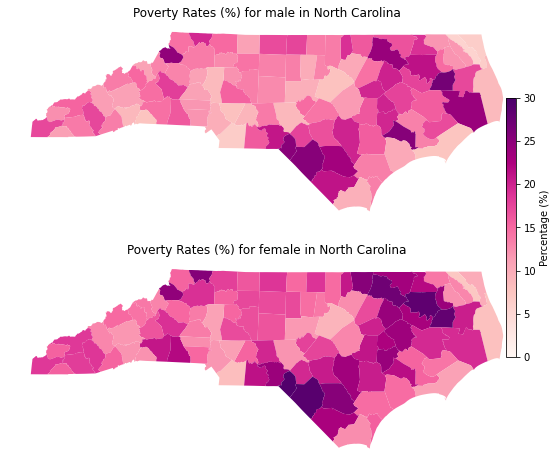

In [184]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize = (14, 8))
for index,ax in enumerate(axes.flat):
    im = plot_.plot(column = sex_cols[index], ax = ax, cmap = "RdPu", vmin=0, vmax=30)
    im.set_title(f'Poverty Rates (%) for {sex_cols[index]} in North Carolina', fontdict = {'fontsize': '12', 'fontweight' : '2'})
    im.set_axis_off()
    
cax = fig.add_axes([0.75, 0.3, 0.01, 0.45])
sm = plt.cm.ScalarMappable(cmap="RdPu", norm=plt.Normalize(vmin=0, vmax=30))
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Percentage (%)')

#### Total number of people divided by sex living under poverty

To get the total number of people living under poverty for each county we need to get the rows that contains '_estimate'. We will do the same processing steps using above for percentage.

In [185]:
poverty_sex_esti = poverty_sex[poverty_sex['counties'].str.contains('_estimate')].copy()
poverty_sex_esti = poverty_sex_esti.replace(',', '', regex=True)
poverty_sex_esti[sex_cols] = poverty_sex_esti[sex_cols].apply(pd.to_numeric, errors='coerce')
poverty_sex_esti.sort_values(by=sex_cols)
poverty_sex_esti.loc[:,"CO_NAME"] = [n.replace('_estimate','').upper() for n in poverty_sex_esti.counties.to_list()]
plot_ = counties.merge(poverty_sex_esti, how='inner', on='CO_NAME')

#### Ploting data for total number of people divided by sex living under poverty  
For these maps, we need to calculate the maximum value in the dataframe to normalize the color pallete of the both maps. We do that by calculating **vmax**.

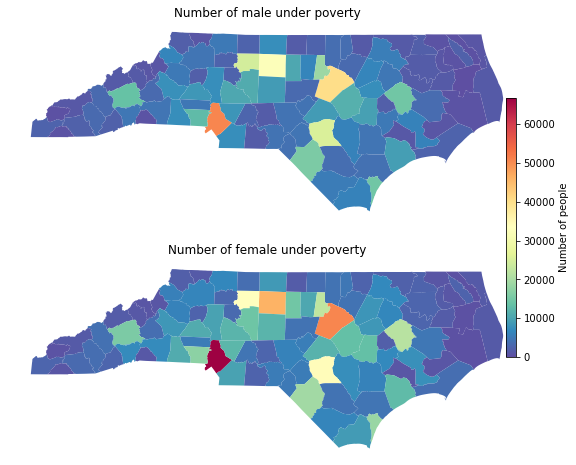

In [186]:
vmax = plot_[sex_cols].max()[1] # get max between female and male

fig, axes = plt.subplots(nrows=2, ncols=1,figsize = (14, 8))
for index,ax in enumerate(axes.flat):
    im = plot_.plot(column = sex_cols[index], ax = ax, cmap = "Spectral_r", vmin=0, vmax=vmax)
    im.set_title(f'Number of {sex_cols[index]} under poverty', fontdict = {'fontsize': '12', 'fontweight' : '2'})
    im.set_axis_off()
    
cax = fig.add_axes([0.75, 0.3, 0.01, 0.45])
sm = plt.cm.ScalarMappable(cmap="Spectral_r", norm=plt.Normalize(vmin=0, vmax=vmax))
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Number of people')

### Exploring poverty data and dividing total number of people by race

Ploting the total number of people living under poverty for the top 10 most populated counties divided by race

Row: 15 -> White alone  
Row: 16 -> Black or African American alone  
Row: 18 -> Asian alone  
Row: 22 -> Hispanic or Latino origin (of any race)  

Here we will follow similar processing used for the poverty percentage and total number of people living under poverty.

In [114]:
# define columns
cols = ["White","Black or African American","Asian","Hispanic or Latino"]

# select the target rows while avoiding the last 3 columns
poverty_race = poverty.iloc[[15,16,18,22],:-3]

# transpose and reset index
poverty_race = poverty_race.T.reset_index() 

# rename columns
poverty_race.columns = ['counties'] + cols 

# drop first row (meaningless row)
poverty_race = poverty_race.drop(poverty_race.index[0])

Get the estimates per race per county, and print the top 10 counties with the highest number of people under poverty.

In [187]:
poverty_race_esti = poverty_race[poverty_race['counties'].str.contains('_estimate')].copy()
poverty_race_esti = poverty_race_esti.replace(',', '', regex=True)
poverty_race_esti[cols] = poverty_race_esti[cols].apply(pd.to_numeric, errors='coerce')

# adding a new columns to the dataframe; total number of poverty including all races
poverty_race_esti.loc[:,"total"] = poverty_race_esti.iloc[:, 1:].sum(axis=1) 

# add the county name with only the first letter capitalized using the function title()
poverty_race_esti.loc[:,"county_name"] = [n.replace('_estimate','').title() for n in poverty_race_esti.counties.to_list()]

# sort values in descending order to get the top 10 counties in total number of people
plot_ = poverty_race_esti.sort_values(by='total',ascending=False).head(10)[cols+['county_name']].reset_index(drop=True)

# get top 10 counties and their index to plot
top10 = pd.DataFrame({'county_name':plot_.county_name.tolist(),'county_index':plot_.index.tolist()})

print(f'The Top 10 most populated counties are: {top10.county_name.tolist()}.')

The Top 10 most populated counties are: ['Mecklenburg', 'Wake', 'Guilford', 'Forsyth', 'Cumberland', 'Durham', 'Pitt', 'New Hanover', 'Buncombe', 'Gaston'].


Ploting a bar graph with the top 10 counties with the highest number of people living under poverty divided by race.

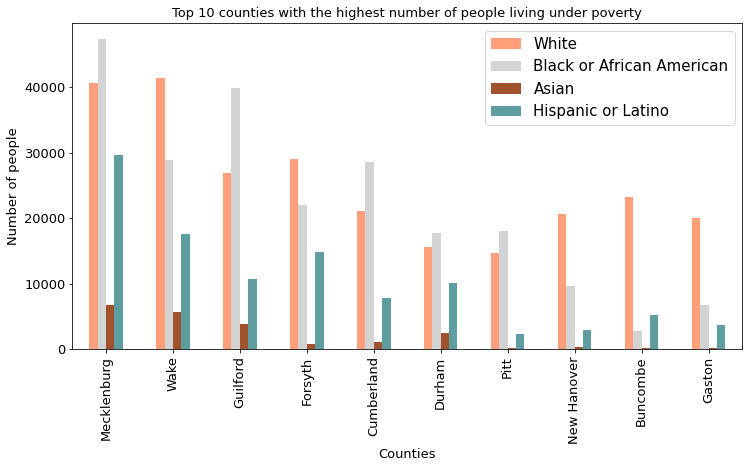

In [189]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (12, 6))
ax = plot_.plot(x='county_name',ax=ax,
           kind='bar',
           stacked=False,
           color=['lightsalmon','lightgrey','sienna','cadetblue'],
           title='Top 10 counties with the highest number of people living under poverty')
ax.set_xlabel('Counties')
ax.set_ylabel('Number of people')

# to increase font size
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(13)

plt.legend(fontsize=15)
plt.show()

Ploting percentage of people living under poverty for the top 10 counties with the highest number of people living under poverty divided by race. 

In [190]:
poverty_race_perc = poverty_race[poverty_race['counties'].str.contains('_percentage')].copy() 
poverty_race_perc = poverty_race_perc.replace('%', '', regex=True) # replace %
poverty_race_perc[cols] = poverty_race_perc[cols].apply(pd.to_numeric, errors='coerce') # transform object to numbers
poverty_race_perc.loc[:,"county_name"] = [n.replace('_percentage','').title() for n in poverty_race_perc.counties.to_list()]

plot_ = poverty_race_perc.merge(top10,how='inner',on='county_name')

# using the county index to keep the same order
plot_ = plot_.sort_values(by='county_index',ascending=True) 

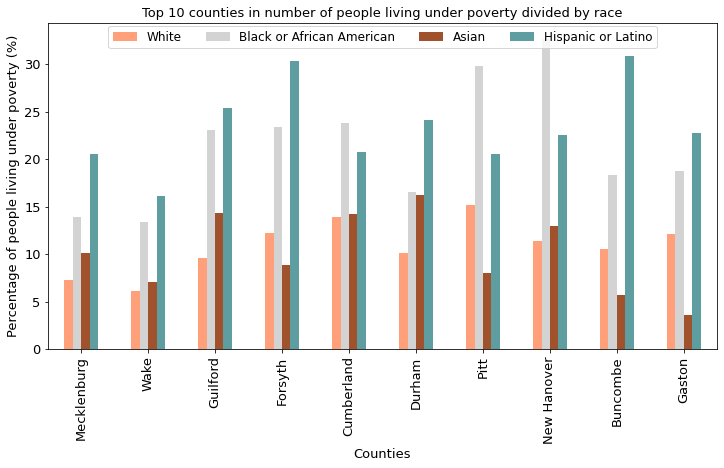

In [191]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (12, 6))
ax = plot_.iloc[:,0:-1].plot(x='county_name',ax=ax,
           kind='bar',
           stacked=False,
           color=['lightsalmon','lightgrey','sienna','cadetblue'],
           title='Top 10 counties in number of people living under poverty divided by race')
ax.set_xlabel('Counties')
ax.set_ylabel('Percentage of people living under poverty (%)')
ax.legend(loc='upper center',fontsize = 12,bbox_to_anchor=(0.5, 1.01),ncol=4)

# to increase font size
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(13)
plt.show()

#### Exploring the how the Gini Index changed over the years in North Carolina
Define a function to help us load multiple csvs and process them at the same time. We will do similar processing steps used above, however, now we are wrapping the steps within a function that will be used in a loop.

In [192]:
def fix_df(path_to_df):
    '''simple function to fix the dataframe as we want.
    '''
    df = pd.read_csv(path_to_df)
    year = str(path_to_df).split('_')[-1].replace('.csv','')

    col_names = df.columns.to_list()
    for index,col in enumerate(col_names):
        col = col.replace(' County, North Carolina!!Estimate','')
        col_names[index] = col

    df.columns = col_names
    df = df.T.reset_index() # transpose and reset index
    df.columns = ['county_name','gini_index'] # rename columns
    df = df.drop(df.index[0]) # drop first row
    df.loc[:,"year"] = [year] * len(df) # add year column
    df = df[:-1] # to drop last row

    return df

Return a list of pandas dataframes using map function, and then, pd.concat to combine all dataframes at once!

In [193]:
# list all csv files within folder
list_csvs = list(Path('data/gini_index/').rglob('*.csv')) 

# mapping fix_df over list_csvs
gini = pd.concat(list(map(fix_df,list_csvs)))

# transform variable to numeric
gini['gini_index'] = gini[['gini_index']].apply(pd.to_numeric, errors='coerce')

gini.tail()

,county_name,gini_index,year
96,Wayne,0.4691,2020
97,Wilkes,0.4520,2020
98,Wilson,0.4633,2020
99,Yadkin,0.4402,2020
100,Yancey,0.4506,2020


#### The 2010 and 2020 Gini Index in North Carolina
To plot the 2010 and 2020 Gini Index we will need to combined the Gini Index values with the counties shapefile (i.e., object **counties**), and the years will be added as columns. Note that the Gini Index is not available for all counties in 2010.

In [194]:
# preparing the 2010 and 2020 indexes
gini_sub = gini[gini.year=='2020'][['county_name','gini_index']].copy()
gini_sub = gini_sub.rename(columns={"gini_index": "gini_2020"})
gini_sub = gini_sub.merge(gini[gini.year=='2010'][['county_name','gini_index']],how='outer',on='county_name')
gini_sub = gini_sub.rename(columns={"gini_index": "gini_2010"})

# adjust county name to match our counties shp
gini_sub.loc[:,"CO_NAME"] = [n.upper() for n in gini_sub.county_name.to_list()] 

# calculate percent change in gini index
gini_sub.loc[:,"gini_change"] = ((gini_sub.gini_2010-gini_sub.gini_2020)/gini_sub.gini_2020)*100 

plot_ = counties.merge(gini_sub, how='inner', on='CO_NAME')

Ploting the Gini Index for 2010 and 2020.

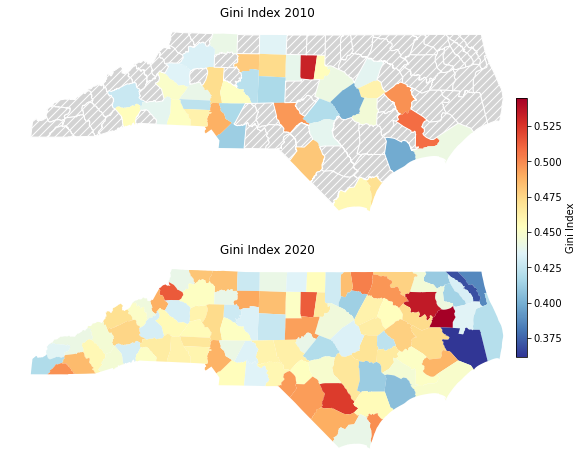

In [195]:
# plotting 
gini_yrs = ['gini_2010','gini_2020']

# for missing info
kwargs = {"color": "lightgrey","edgecolor": "white","hatch": "///","label": "Missing values"}

# for normalization min and max Gini Index values
vmin, vmax = plot_[gini_yrs].min()[-1], plot_[gini_yrs].max()[-1]

fig, axes = plt.subplots(nrows=2, ncols=1,figsize = (14, 8))
for index,ax in enumerate(axes.flat):
    im = plot_.plot(column = gini_yrs[index], ax = ax, cmap = "RdYlBu_r", vmin=vmin, vmax=vmax, missing_kwds=kwargs)
    im.set_title(f'Gini Index {gini_yrs[index][-4:]}', fontdict = {'fontsize': '12', 'fontweight' : '2'})
    im.set_axis_off()
    
cax = fig.add_axes([0.76, 0.3, 0.01, 0.45])
sm = plt.cm.ScalarMappable(cmap="RdYlBu_r", norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Gini Index')

Plotting the Gini Index percent change between 2010 and 2020.

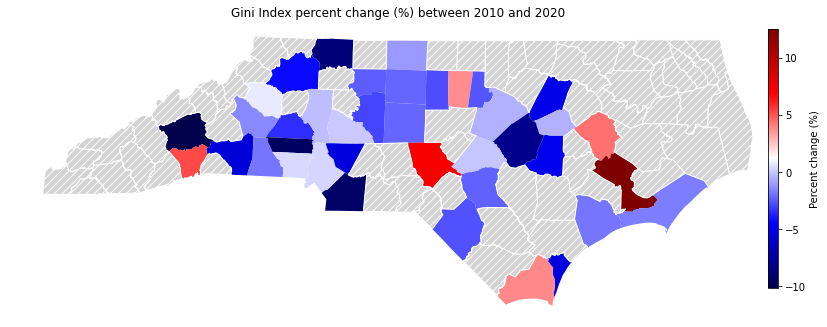

In [196]:
vmin, vmax = plot_['gini_change'].min(), plot_['gini_change'].max()

fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (14, 8))
im = plot_.plot(column = 'gini_change', ax = ax, cmap = "seismic", vmin=vmin, vmax=vmax, missing_kwds=kwargs)
im.set_title(f'Gini Index percent change (%) between 2010 and 2020', fontdict = {'fontsize': '12', 'fontweight': '2'})
im.set_axis_off()
cax = fig.add_axes([0.88, 0.3, 0.01, 0.45])
sm = plt.cm.ScalarMappable(cmap="seismic", norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Percent change (%)')

Selecting the top 10 counties with the highest number of people living under poverty and plot the time series of their Gini Index.

In [197]:
counties_top10 = top10.county_name.tolist()
gini_top10 = gini[gini.county_name.isin(counties_top10)].copy()
gini_top10['year'] = gini_top10['year'].apply(pd.to_numeric, errors='coerce')
gini_top10.head()

,county_name,gini_index,year
3,Buncombe,0.427,2010
11,Cumberland,0.438,2010
13,Durham,0.454,2010
14,Forsyth,0.479,2010
15,Gaston,0.461,2010


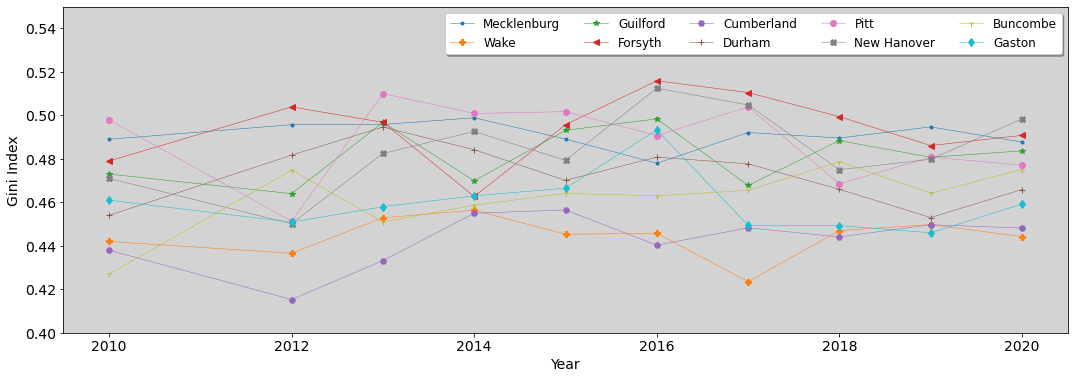

In [198]:
# symbols and colors for the top 10 counties
symbols = [".","P","*","<","H","+","o","X","1","d"]
colors = [c for c in mcolors.TABLEAU_COLORS]

fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (18, 6))
for index,c in enumerate(counties_top10):
    mkr,col = symbols[index],colors[index]
    ax.plot('year','gini_index',data=gini_top10[gini_top10.county_name==c],marker=mkr, color=col,linewidth=.5,label=c)
ax.legend(ncol=5,fontsize = 12,fancybox=True,shadow=True)
ax.set_ylabel('Gini Index')
ax.set_xlabel('Year')
ax.set_facecolor('lightgrey')
ax.set_ylim(0.4,0.55)

# to increase font size
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
plt.show()